<a href="https://colab.research.google.com/github/stefsoliveira/InteliCipes/blob/colab-complete/InteliCipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and data import

### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import sklearn.cluster as clu
from scipy.stats import norm
import seaborn as sns
from random import seed, randint, random
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d

### Importing the dataset from the google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the tables

In [ ]:
recipes = pd.read_csv('/content/drive/My Drive/InteliCipes/RAW_recipes.csv')
interactions = pd.read_csv('/content/drive/My Drive/InteliCipes/RAW_interactions.csv')

### Printing the recipes and interactions tables

In [ ]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


## Sort recipes by id

In [ ]:
recipes = recipes.sort_values("id", ascending=True)
recipes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
126987,low fat berry blue frozen dessert,38,1485,1533,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",13,"['toss 2 cups berries with sugar', 'let stand ...","this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...",4
23695,biryani,39,265,1567,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",17,['soak saffron in warm milk for 5 minutes and ...,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",26
22701,best lemonade,40,35,1566,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",8,"['into a 1 quart jar with tight fitting lid , ...",this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...",6
36412,carina s tofu vegetable kebabs,41,1460,1586,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",18,"['drain the tofu , carefully squeezing out exc...",this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...",15
22217,best blackbottom pie,43,140,34879,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",35,"['graham cracker crust: in small bowl , combin...","sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...",15
...,...,...,...,...,...,...,...,...,...,...,...,...
13104,bailey s chocotini,537459,10,400708,2018-11-10,"['15-minutes-or-less', 'time-to-make', 'course...","[220.7, 15.0, 49.0, 2.0, 3.0, 30.0, 4.0]",5,"['to layer: add chocolate liqueur to glass', '...",a recipe that recipe complements the cocoa in ...,"['baileys irish cream', 'chocolate liqueur', '...",3
1547,5 ingredient salted caramel crumble bars,537485,45,2000378667,2018-11-12,"['60-minutes-or-less', 'time-to-make', 'course...","[52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0]",21,"['1', 'heat oven to 350f spray 8-inch square p...",delicious,"['pillsbury sugar cookie dough', 'caramel topp...",5
137661,moist gingerbread cake,537543,55,2001201872,2018-11-16,"['60-minutes-or-less', 'time-to-make', 'course...","[1617.0, 104.0, 213.0, 8.0, 40.0, 203.0, 80.0]",8,"['preheat the oven to 350&deg', 'f grease a lo...",a slightly sticky loaf cake flavoured with gin...,"['unsalted butter', 'applesauce', 'egg', 'unsu...",10
145532,nutcracker peppermint red velvet cake pops,537671,135,2002198506,2018-11-28,"['time-to-make', 'course', 'preparation', 'occ...","[207.9, 12.0, 93.0, 10.0, 6.0, 8.0, 10.0]",54,"['before you begin , you will need to gather t...",rich red velvet cake combines with cool pepper...,"[""devil's food cake mix"", 'eggs', 'buttermilk'...",12


### Sort interactions by id (recipe_id)


In [ ]:
interactions = interactions.sort_values("recipe_id", ascending=True)
interactions

,user_id,recipe_id,date,rating,review
110594,1060485,38,2009-01-15,4,very good!! the directions were alittle weird ...
110595,1802956262,38,2014-07-22,4,This does taste great! I think the recipe need...
110596,2123645,38,2014-08-14,4,Tasty and refreshing! I love the creamy flavor...
110593,596506,38,2008-02-13,5,"Yummy, yummy, yummy! I am a big fan of fruit a..."
13353,393254,39,2007-01-20,3,I have an Indian friend who made this dish for...
...,...,...,...,...,...
132591,305531,537459,2018-11-13,5,Yum. What's not to like with this one. It was ...
1038794,2001297534,537485,2018-11-17,5,I made this recipe as written. It was easy to ...
738515,2002102502,537543,2018-12-15,0,I Didn't see pumpkin puree in ingredients just...
431814,2002326807,537671,2018-12-15,0,"These are an absolute work of art, but just to..."


#Exploratory Data Analysis (EDA)

### Best rated recipes chart

In [ ]:
#getting the average rating
avg_rating = interactions.groupby("recipe_id").mean()["rating"]
avg_rating

recipe_id
38        4.250000
39        3.000000
40        4.333333
41        4.500000
43        1.000000
            ...   
537459    5.000000
537485    5.000000
537543    0.000000
537671    0.000000
537716    5.000000
Name: rating, Length: 231637, dtype: float64

In [ ]:
#creating a new table and incluing the average rating
rated_recipes = recipes[["id","name"]]
rated_recipes["avg_rating"] = avg_rating
rated_recipes = rated_recipes.sort_values("avg_rating", ascending=False)
rated_recipes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,name,avg_rating
173653,466807,rice krispy treats,5.0
176878,165345,romano s macaroni grill chicken cannelloni,5.0
170120,165379,rainbow coleslaw,5.0
142421,379020,n y c chicken fried rice,5.0
152487,165383,papa bear s baked italian lemon chicken,5.0
...,...,...,...
172553,537429,red wine braised short ribs with fingerlings p...,NaN
13104,537459,bailey s chocotini,NaN
1547,537485,5 ingredient salted caramel crumble bars,NaN
137661,537543,moist gingerbread cake,NaN


In [ ]:
recipes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
126987,low fat berry blue frozen dessert,38,1485,1533,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",13,"['toss 2 cups berries with sugar', 'let stand ...","this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...",4
23695,biryani,39,265,1567,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",17,['soak saffron in warm milk for 5 minutes and ...,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",26
22701,best lemonade,40,35,1566,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",8,"['into a 1 quart jar with tight fitting lid , ...",this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...",6
36412,carina s tofu vegetable kebabs,41,1460,1586,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",18,"['drain the tofu , carefully squeezing out exc...",this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...",15
22217,best blackbottom pie,43,140,34879,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",35,"['graham cracker crust: in small bowl , combin...","sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...",15
...,...,...,...,...,...,...,...,...,...,...,...,...
13104,bailey s chocotini,537459,10,400708,2018-11-10,"['15-minutes-or-less', 'time-to-make', 'course...","[220.7, 15.0, 49.0, 2.0, 3.0, 30.0, 4.0]",5,"['to layer: add chocolate liqueur to glass', '...",a recipe that recipe complements the cocoa in ...,"['baileys irish cream', 'chocolate liqueur', '...",3
1547,5 ingredient salted caramel crumble bars,537485,45,2000378667,2018-11-12,"['60-minutes-or-less', 'time-to-make', 'course...","[52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0]",21,"['1', 'heat oven to 350f spray 8-inch square p...",delicious,"['pillsbury sugar cookie dough', 'caramel topp...",5
137661,moist gingerbread cake,537543,55,2001201872,2018-11-16,"['60-minutes-or-less', 'time-to-make', 'course...","[1617.0, 104.0, 213.0, 8.0, 40.0, 203.0, 80.0]",8,"['preheat the oven to 350&deg', 'f grease a lo...",a slightly sticky loaf cake flavoured with gin...,"['unsalted butter', 'applesauce', 'egg', 'unsu...",10
145532,nutcracker peppermint red velvet cake pops,537671,135,2002198506,2018-11-28,"['time-to-make', 'course', 'preparation', 'occ...","[207.9, 12.0, 93.0, 10.0, 6.0, 8.0, 10.0]",54,"['before you begin , you will need to gather t...",rich red velvet cake combines with cool pepper...,"[""devil's food cake mix"", 'eggs', 'buttermilk'...",12


<BarContainer object of 10 artists>

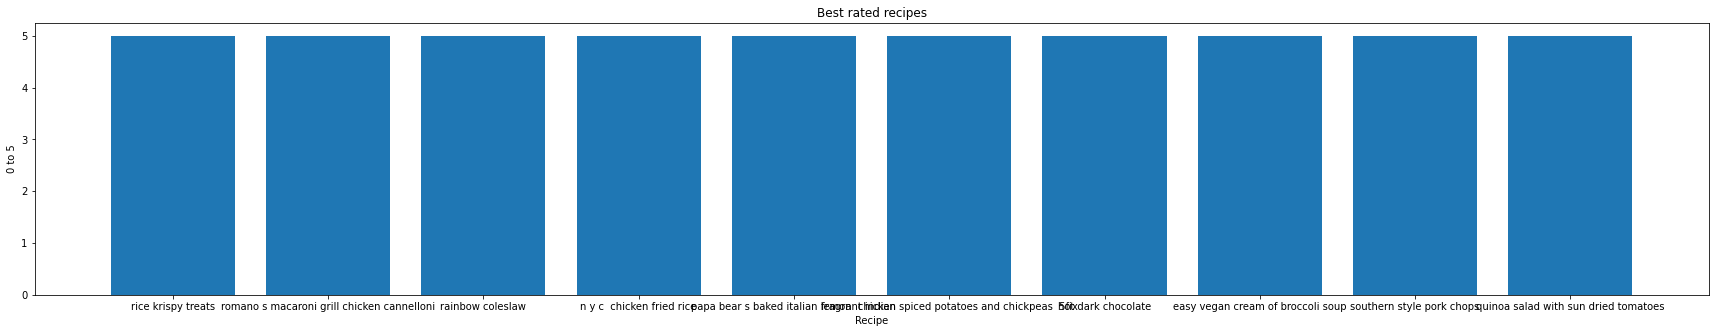

In [ ]:
#generating the chart
plot_best_recipes = rated_recipes[["name","avg_rating"]].head(10)
index = plot_best_recipes["name"]
tvotos = plot_best_recipes["avg_rating"]
plt.figure (figsize=(30,5))
plt.title("Best rated recipes")
plt.xlabel("Recipe")
plt.ylabel("0 to 5")
plt.bar(x=index, height=tvotos)

### Minutes per recipe chart

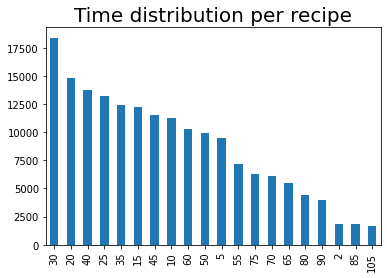

In [ ]:
plot_recipes_minutes = recipes["minutes"].value_counts()[:20]

plt.title("Time distribution per recipe",fontsize=20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plot_recipes_minutes.plot(kind="bar")
plt.show()

### Number of steps per recipe chart

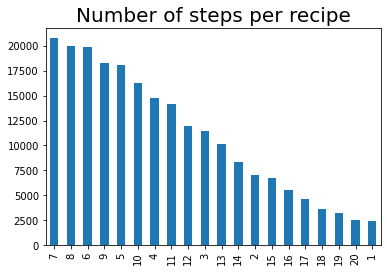

In [ ]:
plot_recipes_steps = recipes["n_steps"].value_counts()[:20]

plt.title("Number of steps per recipe",fontsize=20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plot_recipes_steps.plot(kind="bar")
plt.show()

### Number of ingredients per recipe chart

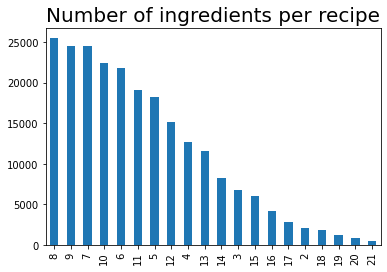

In [ ]:
plot_recipes_ingredients = recipes["n_ingredients"].value_counts()[:20]

plt.title("Number of ingredients per recipe",fontsize=20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plot_recipes_ingredients.plot(kind="bar")
plt.show()

### Analyzing the number of steps 
Using the Empirical Cumulative Distribution Function (ECDF)


In [ ]:
def ecdf(recipes):
  n = len(recipes)
  x = np.sort(recipes)
  y = np.arange(1,n+1)/n
  return x,y 


In [ ]:
x_vers, y_vers = ecdf(recipes['n_steps'])

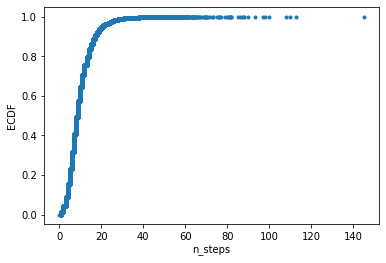

In [ ]:
plt.xlabel('n_steps')
plt.ylabel('ECDF')
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')


PT: Esse gráfico mostra que a maioria das receitas (aprox. 90%) tem até 20 passos para execução. Apenas uma parcela pequena da base possui mais que 20, chegando até uma receita com 140 passos.

### Analyzing the number of ingredients
Using the Empirical Cumulative Distribution Function (ECDF)


In [ ]:
def ecdf(recipes):
  n = len(recipes)
  x = np.sort(recipes)
  y = np.arange(1,n+1)/n
  return x,y 


In [ ]:
x_vers, y_vers = ecdf(recipes['n_ingredients'])

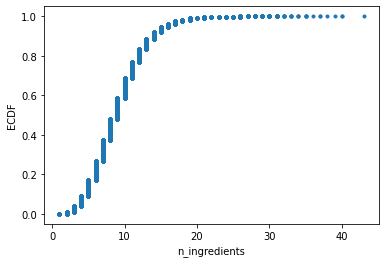

In [ ]:
plt.xlabel('n_ingredients')
plt.ylabel('ECDF')
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

PT: Esse gráfico nos mostra que a maioria das receitas tem até 20 ingredientes. Apenas uma parcela pequena da base possui mais que 20, chegando até uma receita mais que 40 ingredientes.

### Analyzing the number of ratings

Using the Empirical Cumulative Distribution Function (ECDF)


In [ ]:
def ecdf(rated_recipes):
  n = len(rated_recipes)
  x = np.sort(rated_recipes)
  y = np.arange(1,n+1)/n
  return x,y 


In [ ]:
x_vers, y_vers = ecdf(rated_recipes['avg_rating'])

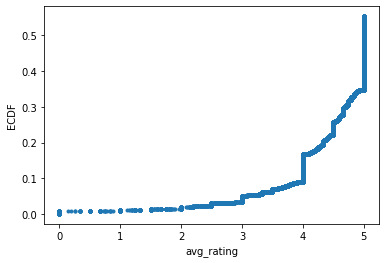

In [ ]:
plt.xlabel('avg_rating')
plt.ylabel('ECDF')
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

PT: O gráfico mostra que aprox. 60% das receitas possuem avaliação média < 5 e 40% possui avaliação média igual a 5.

###Statistical Synthesis 


In [ ]:
recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


In [ ]:
interactions.describe()


,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


### Normal distribution: number of steps 



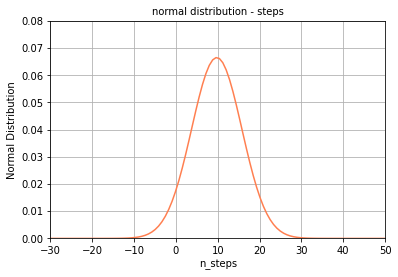

In [ ]:
x_min = -30
x_max = 50

mean = np.mean(recipes['n_steps'])
std = np.std(recipes['n_steps'])

x = np.linspace(x_min, x_max, 100)

y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)
plt.ylim(0,0.08)

plt.title('normal distribution - steps',fontsize=10)

plt.xlabel('n_steps')
plt.ylabel('Normal Distribution')

plt.savefig("normal_distribution.png")
plt.show()

PT: Neste gráfico, diferentemente do gráfico acima, temos uma correlação entre o número de ingredientes e de passos de uma receita. Vemos também que a maior parte da base possui aproximadamente 20 ingredientes e 50 passos.

###Normal distribution: number of ingredients


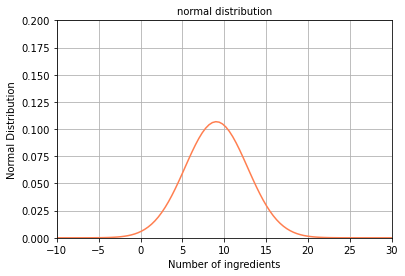

In [ ]:
x_min = -10
x_max = 30

mean = np.mean(recipes['n_ingredients'])
std = np.std(recipes['n_ingredients'])

x = np.linspace(x_min, x_max, 100)

y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)
plt.ylim(0,0.2)

plt.title('normal distribution',fontsize=10)

plt.xlabel('Number of ingredients')
plt.ylabel('Normal Distribution')

plt.savefig("normal_distribution.png")
plt.show()

PT: Neste gráfico, diferentemente do gráfico acima, temos uma correlação entre o número de ingredientes e de passos de uma receita. Vemos também que a maior parte da base possui aproximadamente 20 ingredientes e 50 passos.

### Correlation between the variables 

In [ ]:
r = recipes.corr()
print (r)

                      id   minutes  contributor_id   n_steps  n_ingredients
id              1.000000  0.000582        0.114323  0.064512       0.039227
minutes         0.000582  1.000000       -0.000105 -0.000257      -0.000592
contributor_id  0.114323 -0.000105        1.000000  0.038569       0.019602
n_steps         0.064512 -0.000257        0.038569  1.000000       0.427705
n_ingredients   0.039227 -0.000592        0.019602  0.427705       1.000000


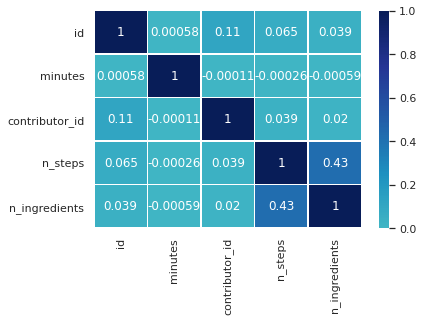

In [ ]:
np.random.seed(0)
sns.set_theme()
ax = sns.heatmap(r,annot=True,vmin=0, vmax=1, linewidths=.5,center=0,cmap="YlGnBu")

PT: A correlação representa como uma variável tende a aumentar ou diminuir, quando outra variável tende a aumentar ou diminuir em paralelo. O coeficiente de correlação varia entre -1 a 1. Nesse gráfico, vemos que, como era de se esperar, o número de ingredientes tem correlação com o número de passos de uma receita, já que a correlação foi positiva (0.43), ou seja, quanto maior o número de ingredientes, maior o número de passos de uma receita.  Outra análise interessante é que a quantidade de passos não expressou uma correlação significativa com o tempo de preparo.

### Analyzing the number of steps and ingredients of a recipe



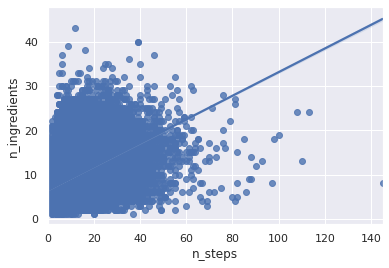

In [ ]:
sns.regplot(x="n_steps", y="n_ingredients", data=recipes)

PT: Neste gráfico temos uma correlação entre o número de ingredientes e de passos de uma receita. Vemos também que a maior parte da base possui aproximadamente 20 ingredientes e 50 passos.

#Data cleaning

In [ ]:
# Removing columns that will not serve
recipes=recipes.drop(columns=['contributor_id'])
print(recipes.columns)

Index(['name', 'id', 'minutes', 'submitted', 'tags', 'nutrition', 'n_steps',
       'steps', 'description', 'ingredients', 'n_ingredients'],
      dtype='object')


In [ ]:
#Querying null values
print(recipes.isnull().any())

name              True
id               False
minutes          False
submitted        False
tags             False
nutrition        False
n_steps          False
steps            False
description       True
ingredients      False
n_ingredients    False
dtype: bool


In [ ]:
#Removing null values
recipes.dropna(axis=0, inplace=True)
recipes.isnull().any()

name             False
id               False
minutes          False
submitted        False
tags             False
nutrition        False
n_steps          False
steps            False
description      False
ingredients      False
n_ingredients    False
dtype: bool

### Indexing

In [ ]:
recipes.index

Int64Index([126987,  23695,  22701,  36412,  22217,  32273,   1968,  43411,
            127011, 125625,
            ...
             34404,  57639, 147854, 172553,  89909,  13104,   1547, 137661,
            145532, 136065],
           dtype='int64', length=226657)

###Removing parentesis

In [ ]:
def remove_parenteses(item):
    if '(' in item:
        return item.replace('(','').replace(')','')
    else:
        return item
    
recipes.name.head().apply(remove_parenteses)

126987    low fat berry blue frozen dessert
23695                               biryani
22701                         best lemonade
36412        carina s tofu vegetable kebabs
22217                  best blackbottom pie
Name: name, dtype: object

In [ ]:
recipes.nutrition.head().apply(remove_parenteses)
nutrition_clean = recipes['nutrition'].str.extract('\[(.*?)\]', expand=False)
nutrition_clean

126987          170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0
23695      1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0
22701           311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0
36412       536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0
22217       437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0
                              ...                     
13104           220.7, 15.0, 49.0, 2.0, 3.0, 30.0, 4.0
1547                52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0
137661    1617.0, 104.0, 213.0, 8.0, 40.0, 203.0, 80.0
145532         207.9, 12.0, 93.0, 10.0, 6.0, 8.0, 10.0
136065       407.9, 34.0, 21.0, 49.0, 28.0, 64.0, 12.0
Name: nutrition, Length: 226657, dtype: object

In [ ]:
recipes["nutrition"] = nutrition_clean
recipes.head()

,name,id,minutes,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
126987,low fat berry blue frozen dessert,38,1485,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0",13,"['toss 2 cups berries with sugar', 'let stand ...","this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...",4
23695,biryani,39,265,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0",17,['soak saffron in warm milk for 5 minutes and ...,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",26
22701,best lemonade,40,35,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0",8,"['into a 1 quart jar with tight fitting lid , ...",this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...",6
36412,carina s tofu vegetable kebabs,41,1460,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0",18,"['drain the tofu , carefully squeezing out exc...",this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...",15
22217,best blackbottom pie,43,140,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0",35,"['graham cracker crust: in small bowl , combin...","sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...",15


### Modify type

In [ ]:
recipes.minutes=recipes.minutes.astype('int32')
recipes.n_steps=recipes.n_steps.astype('int32')
recipes.n_ingredients=recipes.n_ingredients.astype('int32')

### General dataset information

In [ ]:
recipes.head()

,name,id,minutes,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
126987,low fat berry blue frozen dessert,38,1485,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0",13,"['toss 2 cups berries with sugar', 'let stand ...","this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...",4
23695,biryani,39,265,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0",17,['soak saffron in warm milk for 5 minutes and ...,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",26
22701,best lemonade,40,35,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0",8,"['into a 1 quart jar with tight fitting lid , ...",this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...",6
36412,carina s tofu vegetable kebabs,41,1460,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0",18,"['drain the tofu , carefully squeezing out exc...",this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...",15
22217,best blackbottom pie,43,140,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0",35,"['graham cracker crust: in small bowl , combin...","sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...",15


In [ ]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226657 entries, 126987 to 136065
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           226657 non-null  object
 1   id             226657 non-null  int64 
 2   minutes        226657 non-null  int32 
 3   submitted      226657 non-null  object
 4   tags           226657 non-null  object
 5   nutrition      226657 non-null  object
 6   n_steps        226657 non-null  int32 
 7   steps          226657 non-null  object
 8   description    226657 non-null  object
 9   ingredients    226657 non-null  object
 10  n_ingredients  226657 non-null  int32 
dtypes: int32(3), int64(1), object(7)
memory usage: 18.2+ MB


##Spliting nutrition


In [ ]:
nutrition_splitted = recipes["nutrition"].str.split(",")
nutrition_splitted .head()

126987       [170.9,  3.0,  120.0,  1.0,  6.0,  6.0,  12.0]
23695     [1110.7,  90.0,  81.0,  15.0,  126.0,  82.0,  ...
22701        [311.1,  0.0,  308.0,  0.0,  0.0,  0.0,  27.0]
36412     [536.1,  36.0,  128.0,  64.0,  58.0,  19.0,  2...
22217     [437.9,  29.0,  170.0,  11.0,  13.0,  54.0,  1...
Name: nutrition, dtype: object

## Array break

In [ ]:
recipes["calories"] = nutrition_splitted.str.get(0)
recipes["total_fat"] = nutrition_splitted.str.get(1)
recipes["sugar"] = nutrition_splitted.str.get(2)
recipes["sodium"] = nutrition_splitted.str.get(4)
recipes["protein"] = nutrition_splitted.str.get(5)
recipes["saturated_fat"] = nutrition_splitted.str.get(6)
recipes

,name,id,minutes,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat
126987,low fat berry blue frozen dessert,38,1485,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0",13,"['toss 2 cups berries with sugar', 'let stand ...","this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...",4,170.9,3.0,120.0,6.0,6.0,12.0
23695,biryani,39,265,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0",17,['soak saffron in warm milk for 5 minutes and ...,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",26,1110.7,90.0,81.0,126.0,82.0,28.0
22701,best lemonade,40,35,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0",8,"['into a 1 quart jar with tight fitting lid , ...",this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...",6,311.1,0.0,308.0,0.0,0.0,27.0
36412,carina s tofu vegetable kebabs,41,1460,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0",18,"['drain the tofu , carefully squeezing out exc...",this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...",15,536.1,36.0,128.0,58.0,19.0,21.0
22217,best blackbottom pie,43,140,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0",35,"['graham cracker crust: in small bowl , combin...","sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...",15,437.9,29.0,170.0,13.0,54.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,bailey s chocotini,537459,10,2018-11-10,"['15-minutes-or-less', 'time-to-make', 'course...","220.7, 15.0, 49.0, 2.0, 3.0, 30.0, 4.0",5,"['to layer: add chocolate liqueur to glass', '...",a recipe that recipe complements the cocoa in ...,"['baileys irish cream', 'chocolate liqueur', '...",3,220.7,15.0,49.0,3.0,30.0,4.0
1547,5 ingredient salted caramel crumble bars,537485,45,2018-11-12,"['60-minutes-or-less', 'time-to-make', 'course...","52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0",21,"['1', 'heat oven to 350f spray 8-inch square p...",delicious,"['pillsbury sugar cookie dough', 'caramel topp...",5,52.8,3.0,0.0,1.0,1.0,2.0
137661,moist gingerbread cake,537543,55,2018-11-16,"['60-minutes-or-less', 'time-to-make', 'course...","1617.0, 104.0, 213.0, 8.0, 40.0, 203.0, 80.0",8,"['preheat the oven to 350&deg', 'f grease a lo...",a slightly sticky loaf cake flavoured with gin...,"['unsalted butter', 'applesauce', 'egg', 'unsu...",10,1617.0,104.0,213.0,40.0,203.0,80.0
145532,nutcracker peppermint red velvet cake pops,537671,135,2018-11-28,"['time-to-make', 'course', 'preparation', 'occ...","207.9, 12.0, 93.0, 10.0, 6.0, 8.0, 10.0",54,"['before you begin , you will need to gather t...",rich red velvet cake combines with cool pepper...,"[""devil's food cake mix"", 'eggs', 'buttermilk'...",12,207.9,12.0,93.0,6.0,8.0,10.0


## Select the columns

In [ ]:
colRecipes=recipes.loc[:,['id','name', 'calories', 'total_fat', 'sugar', 'sodium', 'protein','saturated_fat']]
colRecipes

,id,name,calories,total_fat,sugar,sodium,protein,saturated_fat
126987,38,low fat berry blue frozen dessert,170.9,3.0,120.0,6.0,6.0,12.0
23695,39,biryani,1110.7,90.0,81.0,126.0,82.0,28.0
22701,40,best lemonade,311.1,0.0,308.0,0.0,0.0,27.0
36412,41,carina s tofu vegetable kebabs,536.1,36.0,128.0,58.0,19.0,21.0
22217,43,best blackbottom pie,437.9,29.0,170.0,13.0,54.0,19.0
...,...,...,...,...,...,...,...,...
13104,537459,bailey s chocotini,220.7,15.0,49.0,3.0,30.0,4.0
1547,537485,5 ingredient salted caramel crumble bars,52.8,3.0,0.0,1.0,1.0,2.0
137661,537543,moist gingerbread cake,1617.0,104.0,213.0,40.0,203.0,80.0
145532,537671,nutcracker peppermint red velvet cake pops,207.9,12.0,93.0,6.0,8.0,10.0


##Converting nutrition info to number (float)

In [ ]:
colRecipes.calories=colRecipes.calories.astype('float32')
colRecipes.total_fat=colRecipes.total_fat.astype('float32')
colRecipes.sugar=colRecipes.sugar.astype('float32')
colRecipes.sodium=colRecipes.sodium.astype('float32')
colRecipes.protein=colRecipes.protein.astype('float32')
colRecipes.saturated_fat=colRecipes.saturated_fat.astype('float32')


In [ ]:
colRecipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226657 entries, 126987 to 136065
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             226657 non-null  int64  
 1   name           226657 non-null  object 
 2   calories       226657 non-null  float32
 3   total_fat      226657 non-null  float32
 4   sugar          226657 non-null  float32
 5   sodium         226657 non-null  float32
 6   protein        226657 non-null  float32
 7   saturated_fat  226657 non-null  float32
dtypes: float32(6), int64(1), object(1)
memory usage: 10.4+ MB


### Delete row

In [ ]:
colRecipes.sort_values(by=["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat"])

,id,name,calories,total_fat,sugar,sodium,protein,saturated_fat
111737,21182,irish matter of fact peas mushy peas,0.000000,0.0,0.0,0.0,0.0,0.0
119684,28881,larry s margaritas,0.000000,0.0,0.0,0.0,0.0,0.0
94066,53039,gomashio toasted sesame salt,0.000000,0.0,0.0,0.0,0.0,0.0
122414,66757,lemon verbena water,0.000000,0.0,0.0,0.0,0.0,0.0
56738,75294,collards southern style,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
34023,18330,caledonian wedding cake,43924.601562,2556.0,18943.0,1103.0,4941.0,2233.0
137181,82848,mmmmmmmmilky way cake,44239.800781,2036.0,17306.0,936.0,1441.0,2565.0
165504,392286,powdered hot cocoa mix,45609.000000,3379.0,16901.0,4356.0,6875.0,1453.0
70467,227470,deep fried prime rib,101614.703125,17183.0,0.0,1271.0,10395.0,1.0


In [ ]:
colRecipes=colRecipes.drop([209453, 70467, 137181])


In [ ]:
colRecipes.sort_values(by=["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat"])

,id,name,calories,total_fat,sugar,sodium,protein,saturated_fat
111737,21182,irish matter of fact peas mushy peas,0.000000,0.0,0.0,0.0,0.0,0.0
119684,28881,larry s margaritas,0.000000,0.0,0.0,0.0,0.0,0.0
94066,53039,gomashio toasted sesame salt,0.000000,0.0,0.0,0.0,0.0,0.0
122414,66757,lemon verbena water,0.000000,0.0,0.0,0.0,0.0,0.0
56738,75294,collards southern style,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
182816,59776,scott hibb s amazing whiskey grilled baby back...,38680.101562,4317.0,185.0,6540.0,4960.0,18.0
78689,48363,easy easy friendship cake,40159.199219,1922.0,1024.0,810.0,1084.0,2275.0
141997,75591,my mercy strawberry cake,42951.601562,2343.0,1544.0,886.0,2155.0,2315.0
34023,18330,caledonian wedding cake,43924.601562,2556.0,18943.0,1103.0,4941.0,2233.0


In [ ]:
colRecipes.sort_values(by=["id","calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat"])
colRecipes

,id,name,calories,total_fat,sugar,sodium,protein,saturated_fat
126987,38,low fat berry blue frozen dessert,170.899994,3.0,120.0,6.0,6.0,12.0
23695,39,biryani,1110.699951,90.0,81.0,126.0,82.0,28.0
22701,40,best lemonade,311.100006,0.0,308.0,0.0,0.0,27.0
36412,41,carina s tofu vegetable kebabs,536.099976,36.0,128.0,58.0,19.0,21.0
22217,43,best blackbottom pie,437.899994,29.0,170.0,13.0,54.0,19.0
...,...,...,...,...,...,...,...,...
13104,537459,bailey s chocotini,220.699997,15.0,49.0,3.0,30.0,4.0
1547,537485,5 ingredient salted caramel crumble bars,52.799999,3.0,0.0,1.0,1.0,2.0
137661,537543,moist gingerbread cake,1617.000000,104.0,213.0,40.0,203.0,80.0
145532,537671,nutcracker peppermint red velvet cake pops,207.899994,12.0,93.0,6.0,8.0,10.0


## Rename column

In [ ]:
recipes.rename(columns={'submitted': 'submitted_recipe'}, inplace=True)
print(recipes.columns)

Index(['name', 'id', 'minutes', 'submitted_recipe', 'tags', 'nutrition',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat'],
      dtype='object')


#Categorizing using K means

In [ ]:
cluster=clu.KMeans(n_clusters=8,init='k-means++')

### Normalization

In [ ]:
def norm(xs):
  x_max=max(xs)
  x_min=min(xs)
  x_range=x_max - x_min
  return xs/x_range

## Recipes - Items by calories & sugar content

In [ ]:
menu_edt=colRecipes.loc[:,['id','calories','sugar']]
menu_edt['calories_norm']=norm(menu_edt['calories'])
menu_edt['sugar_norm']=norm(menu_edt['sugar'])
menu_edt

,id,calories,sugar,calories_norm,sugar_norm
126987,38,170.899994,120.0,0.003747,0.003966
23695,39,1110.699951,81.0,0.024353,0.002677
22701,40,311.100006,308.0,0.006821,0.010178
36412,41,536.099976,128.0,0.011754,0.004230
22217,43,437.899994,170.0,0.009601,0.005618
...,...,...,...,...,...
13104,537459,220.699997,49.0,0.004839,0.001619
1547,537485,52.799999,0.0,0.001158,0.000000
137661,537543,1617.000000,213.0,0.035454,0.007039
145532,537671,207.899994,93.0,0.004558,0.003073


In [ ]:
id = menu_edt["id"]

###Visualizing the data - simple scatter plot

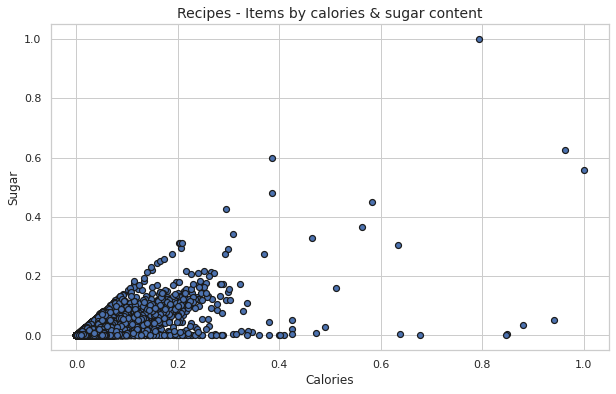

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.scatter(menu_edt['calories_norm'],menu_edt['sugar_norm'],linewidths=1.2,
    edgecolors='k')
plt.xlabel('Calories')
plt.ylabel('Sugar')
plt.title('Recipes - Items by calories & sugar content',size=14)
plt.show()

###K-means k=2 clusters 

In [ ]:
menu_edt.iloc[:,3:]

,calories_norm,sugar_norm
126987,0.003747,0.003966
23695,0.024353,0.002677
22701,0.006821,0.010178
36412,0.011754,0.004230
22217,0.009601,0.005618
...,...,...
13104,0.004839,0.001619
1547,0.001158,0.000000
137661,0.035454,0.007039
145532,0.004558,0.003073


In [ ]:
cluster=clu.KMeans(n_clusters=2)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,3:])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

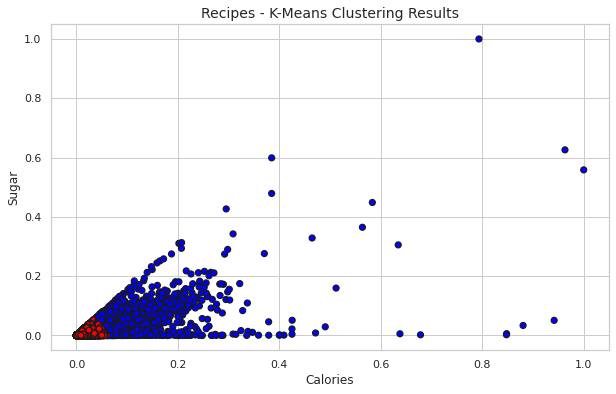

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(menu_edt['calories_norm'],menu_edt['sugar_norm'],linewidths=1.2,
    edgecolors='k',c=menu_edt['clust_col'])
plt.xlabel('Calories')
plt.ylabel('Sugar')
plt.title('Recipes - K-Means Clustering Results',size=14)
plt.show()

In [ ]:
menu_edt

,id,calories,sugar,calories_norm,sugar_norm,cluster,clust_col
126987,38,170.899994,120.0,0.003747,0.003966,0,red
23695,39,1110.699951,81.0,0.024353,0.002677,0,red
22701,40,311.100006,308.0,0.006821,0.010178,0,red
36412,41,536.099976,128.0,0.011754,0.004230,0,red
22217,43,437.899994,170.0,0.009601,0.005618,0,red
...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,0.004839,0.001619,0,red
1547,537485,52.799999,0.0,0.001158,0.000000,0,red
137661,537543,1617.000000,213.0,0.035454,0.007039,0,red
145532,537671,207.899994,93.0,0.004558,0.003073,0,red


In [ ]:
menu_edt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226654 entries, 126987 to 136065
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             226654 non-null  int64  
 1   calories       226654 non-null  float32
 2   sugar          226654 non-null  float32
 3   calories_norm  226654 non-null  float64
 4   sugar_norm     226654 non-null  float64
 5   cluster        226654 non-null  int32  
 6   clust_col      226654 non-null  object 
dtypes: float32(2), float64(2), int32(1), int64(1), object(1)
memory usage: 11.2+ MB


### K-means k=4

In [ ]:
menu_edt.iloc[:,3:]

,calories_norm,sugar_norm,cluster,clust_col
126987,0.003747,0.003966,0,red
23695,0.024353,0.002677,0,red
22701,0.006821,0.010178,0,red
36412,0.011754,0.004230,0,red
22217,0.009601,0.005618,0,red
...,...,...,...,...
13104,0.004839,0.001619,0,red
1547,0.001158,0.000000,0,red
137661,0.035454,0.007039,0,red
145532,0.004558,0.003073,0,red


In [ ]:
menu_edt.iloc[:,3:5]

,calories_norm,sugar_norm
126987,0.003747,0.003966
23695,0.024353,0.002677
22701,0.006821,0.010178
36412,0.011754,0.004230
22217,0.009601,0.005618
...,...,...
13104,0.004839,0.001619
1547,0.001158,0.000000
137661,0.035454,0.007039
145532,0.004558,0.003073


In [ ]:
cluster=clu.KMeans(n_clusters=4)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,3:5])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

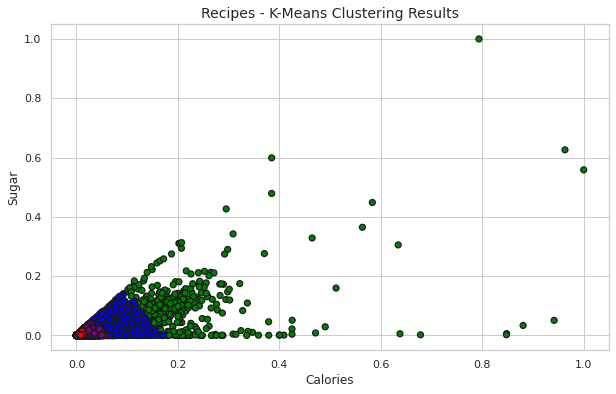

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(menu_edt['calories_norm'],menu_edt['sugar_norm'],linewidths=1.2,
    edgecolors='k',c=menu_edt['clust_col'])
plt.xlabel('Calories')
plt.ylabel('Sugar')
plt.title('Recipes - K-Means Clustering Results',size=14)
plt.show()

In [ ]:
menu_edt

,id,calories,sugar,calories_norm,sugar_norm,cluster,clust_col
126987,38,170.899994,120.0,0.003747,0.003966,0,red
23695,39,1110.699951,81.0,0.024353,0.002677,3,purple
22701,40,311.100006,308.0,0.006821,0.010178,0,red
36412,41,536.099976,128.0,0.011754,0.004230,0,red
22217,43,437.899994,170.0,0.009601,0.005618,0,red
...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,0.004839,0.001619,0,red
1547,537485,52.799999,0.0,0.001158,0.000000,0,red
137661,537543,1617.000000,213.0,0.035454,0.007039,3,purple
145532,537671,207.899994,93.0,0.004558,0.003073,0,red


### K-Means with 8 clusters

In [ ]:
menu_edt.iloc[:,3:5]

,calories_norm,sugar_norm
126987,0.003747,0.003966
23695,0.024353,0.002677
22701,0.006821,0.010178
36412,0.011754,0.004230
22217,0.009601,0.005618
...,...,...
13104,0.004839,0.001619
1547,0.001158,0.000000
137661,0.035454,0.007039
145532,0.004558,0.003073


In [ ]:
cluster=clu.KMeans(n_clusters=8)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,3:5])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['cluster_col']=menu_edt['cluster'].map(clu_col_map)

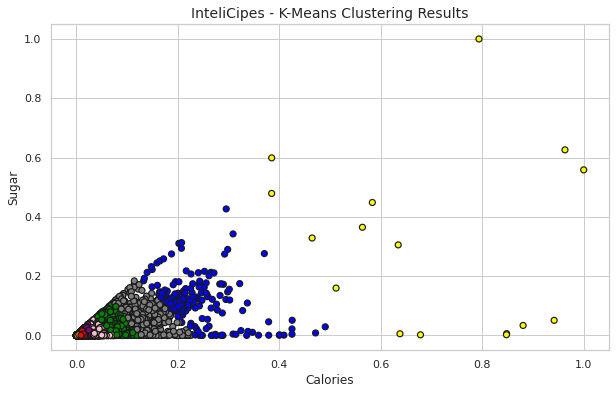

In [ ]:
# Visualize clustered results
plt.figure(figsize=(10,6))
plt.scatter(menu_edt['calories_norm'],menu_edt['sugar_norm'],linewidths=1.2,
    edgecolors='k',c=menu_edt['cluster_col'])
plt.xlabel('Calories')
plt.ylabel('Sugar')
plt.title('InteliCipes - K-Means Clustering Results',size=14)
plt.show()

In [ ]:
menu_edt

,id,calories,sugar,calories_norm,sugar_norm,cluster,clust_col,cluster_col
126987,38,170.899994,120.0,0.003747,0.003966,4,red,orange
23695,39,1110.699951,81.0,0.024353,0.002677,3,purple,purple
22701,40,311.100006,308.0,0.006821,0.010178,0,red,red
36412,41,536.099976,128.0,0.011754,0.004230,0,red,red
22217,43,437.899994,170.0,0.009601,0.005618,0,red,red
...,...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,0.004839,0.001619,4,red,orange
1547,537485,52.799999,0.0,0.001158,0.000000,4,red,orange
137661,537543,1617.000000,213.0,0.035454,0.007039,7,purple,pink
145532,537671,207.899994,93.0,0.004558,0.003073,4,red,orange


In [ ]:
sugar_calories = menu_edt.iloc[:,5:7]
sugar_calories

,cluster,clust_col
126987,4,red
23695,3,purple
22701,0,red
36412,0,red
22217,0,red
...,...,...
13104,4,red
1547,4,red
137661,7,purple
145532,4,red


Delete and re-initialize K-means

In [ ]:
menu_edt=menu_edt.iloc[:,:5]
cluster=clu.KMeans(n_clusters=8,init='k-means++')
menu_edt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226654 entries, 126987 to 136065
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             226654 non-null  int64  
 1   calories       226654 non-null  float32
 2   sugar          226654 non-null  float32
 3   calories_norm  226654 non-null  float64
 4   sugar_norm     226654 non-null  float64
dtypes: float32(2), float64(2), int64(1)
memory usage: 8.6 MB


## Recipes - Items by calories, sugar & total fat content 



In [ ]:
menu_edt=colRecipes.loc[:,['id','calories','sugar','total_fat']]
menu_edt['calories_norm']=norm(menu_edt['calories'])
menu_edt['sugar_norm']=norm(menu_edt['sugar'])
menu_edt['total_fat_norm']=norm(menu_edt['total_fat'])
menu_edt

,id,calories,sugar,total_fat,calories_norm,sugar_norm,total_fat_norm
126987,38,170.899994,120.0,3.0,0.003747,0.003966,0.000693
23695,39,1110.699951,81.0,90.0,0.024353,0.002677,0.020780
22701,40,311.100006,308.0,0.0,0.006821,0.010178,0.000000
36412,41,536.099976,128.0,36.0,0.011754,0.004230,0.008312
22217,43,437.899994,170.0,29.0,0.009601,0.005618,0.006696
...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,15.0,0.004839,0.001619,0.003463
1547,537485,52.799999,0.0,3.0,0.001158,0.000000,0.000693
137661,537543,1617.000000,213.0,104.0,0.035454,0.007039,0.024013
145532,537671,207.899994,93.0,12.0,0.004558,0.003073,0.002771


Visualizing the data - simple scatter plot

Text(0.5, 0, 'Total Fat')

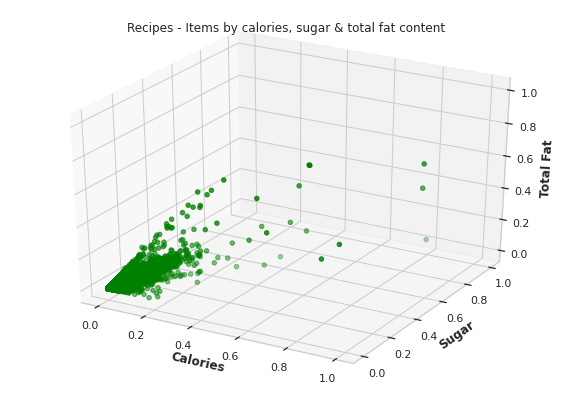

In [ ]:
# creating figure
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")
#creating plot
ax.scatter3D(menu_edt['calories_norm'],menu_edt['sugar_norm'],menu_edt['total_fat_norm'],color="green")
plt.title("Recipes - Items by calories, sugar & total fat content")
ax.set_xlabel('Calories', fontweight ='bold') 
ax.set_ylabel('Sugar', fontweight ='bold') 
ax.set_zlabel('Total Fat', fontweight ='bold')


K-means k=2 clusters

In [ ]:
menu_edt.iloc[:,4:7]

,calories_norm,sugar_norm,total_fat_norm
126987,0.003747,0.003966,0.000693
23695,0.024353,0.002677,0.020780
22701,0.006821,0.010178,0.000000
36412,0.011754,0.004230,0.008312
22217,0.009601,0.005618,0.006696
...,...,...,...
13104,0.004839,0.001619,0.003463
1547,0.001158,0.000000,0.000693
137661,0.035454,0.007039,0.024013
145532,0.004558,0.003073,0.002771


In [ ]:
cluster=clu.KMeans(n_clusters=2)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,4:])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

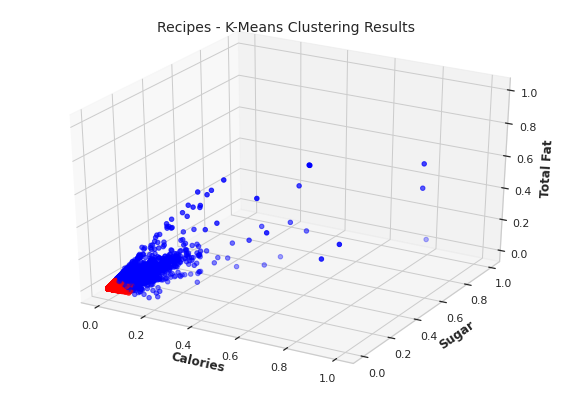

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

ax.scatter3D(menu_edt['calories_norm'],menu_edt['sugar_norm'],menu_edt['total_fat_norm'],c=menu_edt['clust_col'])
plt.title('Recipes - K-Means Clustering Results',size=14)
ax.set_xlabel('Calories', fontweight ='bold') 
ax.set_ylabel('Sugar', fontweight ='bold') 
ax.set_zlabel('Total Fat', fontweight ='bold')

plt.show()

In [ ]:
menu_edt

,id,calories,sugar,total_fat,calories_norm,sugar_norm,total_fat_norm,cluster,clust_col
126987,38,170.899994,120.0,3.0,0.003747,0.003966,0.000693,0,red
23695,39,1110.699951,81.0,90.0,0.024353,0.002677,0.020780,0,red
22701,40,311.100006,308.0,0.0,0.006821,0.010178,0.000000,0,red
36412,41,536.099976,128.0,36.0,0.011754,0.004230,0.008312,0,red
22217,43,437.899994,170.0,29.0,0.009601,0.005618,0.006696,0,red
...,...,...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,15.0,0.004839,0.001619,0.003463,0,red
1547,537485,52.799999,0.0,3.0,0.001158,0.000000,0.000693,0,red
137661,537543,1617.000000,213.0,104.0,0.035454,0.007039,0.024013,0,red
145532,537671,207.899994,93.0,12.0,0.004558,0.003073,0.002771,0,red


K-means k=4 clusters

In [ ]:
menu_edt.iloc[:,4:7]

,calories_norm,sugar_norm,total_fat_norm
126987,0.003747,0.003966,0.000693
23695,0.024353,0.002677,0.020780
22701,0.006821,0.010178,0.000000
36412,0.011754,0.004230,0.008312
22217,0.009601,0.005618,0.006696
...,...,...,...
13104,0.004839,0.001619,0.003463
1547,0.001158,0.000000,0.000693
137661,0.035454,0.007039,0.024013
145532,0.004558,0.003073,0.002771


In [ ]:
cluster=clu.KMeans(n_clusters=4)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,4:7])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

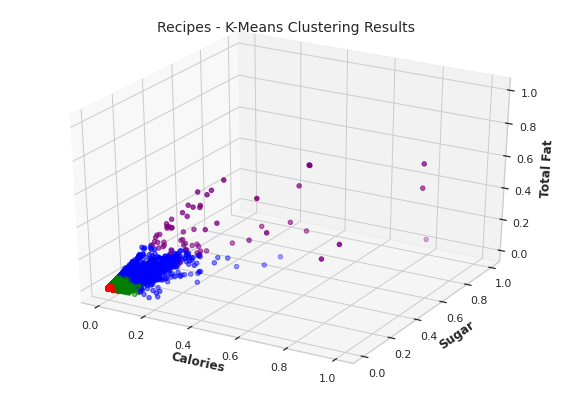

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

ax.scatter3D(menu_edt['calories_norm'],menu_edt['sugar_norm'],menu_edt['total_fat_norm'],c=menu_edt['clust_col'])
plt.title('Recipes - K-Means Clustering Results',size=14)
ax.set_xlabel('Calories', fontweight ='bold') 
ax.set_ylabel('Sugar', fontweight ='bold') 
ax.set_zlabel('Total Fat', fontweight ='bold')

plt.show()

In [ ]:
menu_edt.iloc[:,4:7]

,calories_norm,sugar_norm,total_fat_norm
126987,0.003747,0.003966,0.000693
23695,0.024353,0.002677,0.020780
22701,0.006821,0.010178,0.000000
36412,0.011754,0.004230,0.008312
22217,0.009601,0.005618,0.006696
...,...,...,...
13104,0.004839,0.001619,0.003463
1547,0.001158,0.000000,0.000693
137661,0.035454,0.007039,0.024013
145532,0.004558,0.003073,0.002771


K-means k=8 clusters

In [ ]:
cluster=clu.KMeans(n_clusters=8)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,4:7])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['cluster_col']=menu_edt['cluster'].map(clu_col_map)

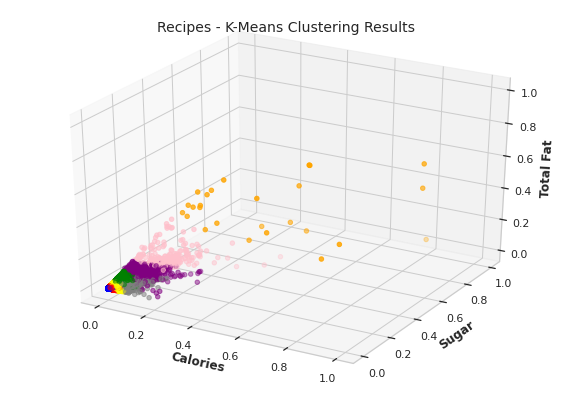

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

ax.scatter3D(menu_edt['calories_norm'],menu_edt['sugar_norm'],menu_edt['total_fat_norm'],c=menu_edt['cluster_col'])
plt.title('Recipes - K-Means Clustering Results',size=14)
ax.set_xlabel('Calories', fontweight ='bold') 
ax.set_ylabel('Sugar', fontweight ='bold') 
ax.set_zlabel('Total Fat', fontweight ='bold')

plt.show()

In [ ]:
menu_edt

,id,calories,sugar,total_fat,calories_norm,sugar_norm,total_fat_norm,cluster,clust_col,cluster_col
126987,38,170.899994,120.0,3.0,0.003747,0.003966,0.000693,1,red,blue
23695,39,1110.699951,81.0,90.0,0.024353,0.002677,0.020780,5,green,yellow
22701,40,311.100006,308.0,0.0,0.006821,0.010178,0.000000,1,red,blue
36412,41,536.099976,128.0,36.0,0.011754,0.004230,0.008312,0,red,red
22217,43,437.899994,170.0,29.0,0.009601,0.005618,0.006696,0,red,red
...,...,...,...,...,...,...,...,...,...,...
13104,537459,220.699997,49.0,15.0,0.004839,0.001619,0.003463,1,red,blue
1547,537485,52.799999,0.0,3.0,0.001158,0.000000,0.000693,1,red,blue
137661,537543,1617.000000,213.0,104.0,0.035454,0.007039,0.024013,5,green,yellow
145532,537671,207.899994,93.0,12.0,0.004558,0.003073,0.002771,1,red,blue


In [ ]:
fat_sugar_calories = menu_edt.iloc[:,7:9]
fat_sugar_calories

,cluster,clust_col
126987,1,red
23695,5,green
22701,1,red
36412,0,red
22217,0,red
...,...,...
13104,1,red
1547,1,red
137661,5,green
145532,1,red


## Recipes - All items

In [ ]:
#reseting kmean
cluster=clu.KMeans(n_clusters=8,init='k-means++')


In [ ]:
menu_edt=colRecipes.loc[:,['id','calories','total_fat','sugar','sodium','protein','saturated_fat']]
menu_edt['calories_norm']=norm(menu_edt['calories'])
menu_edt['total_fat_norm']=norm(menu_edt['total_fat'])
menu_edt['sugar_norm']=norm(menu_edt['sugar'])
menu_edt['sodium_norm']=norm(menu_edt['sodium'])
menu_edt['protein_norm']=norm(menu_edt['protein'])
menu_edt['saturated_fat_norm']=norm(menu_edt['saturated_fat'])
menu_edt

,id,calories,total_fat,sugar,sodium,protein,saturated_fat,calories_norm,total_fat_norm,sugar_norm,sodium_norm,protein_norm,saturated_fat_norm
126987,38,170.899994,3.0,120.0,6.0,6.0,12.0,0.003747,0.000693,0.003966,0.000916,0.000873,0.003991
23695,39,1110.699951,90.0,81.0,126.0,82.0,28.0,0.024353,0.020780,0.002677,0.019231,0.011927,0.009312
22701,40,311.100006,0.0,308.0,0.0,0.0,27.0,0.006821,0.000000,0.010178,0.000000,0.000000,0.008979
36412,41,536.099976,36.0,128.0,58.0,19.0,21.0,0.011754,0.008312,0.004230,0.008852,0.002764,0.006984
22217,43,437.899994,29.0,170.0,13.0,54.0,19.0,0.009601,0.006696,0.005618,0.001984,0.007855,0.006319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,537459,220.699997,15.0,49.0,3.0,30.0,4.0,0.004839,0.003463,0.001619,0.000458,0.004364,0.001330
1547,537485,52.799999,3.0,0.0,1.0,1.0,2.0,0.001158,0.000693,0.000000,0.000153,0.000145,0.000665
137661,537543,1617.000000,104.0,213.0,40.0,203.0,80.0,0.035454,0.024013,0.007039,0.006105,0.029527,0.026605
145532,537671,207.899994,12.0,93.0,6.0,8.0,10.0,0.004558,0.002771,0.003073,0.000916,0.001164,0.003326


K-means k=2 clusters

In [ ]:
menu_edt.iloc[:,7:]

,calories_norm,total_fat_norm,sugar_norm,sodium_norm,protein_norm,saturated_fat_norm
126987,0.003747,0.000693,0.003966,0.000916,0.000873,0.003991
23695,0.024353,0.020780,0.002677,0.019231,0.011927,0.009312
22701,0.006821,0.000000,0.010178,0.000000,0.000000,0.008979
36412,0.011754,0.008312,0.004230,0.008852,0.002764,0.006984
22217,0.009601,0.006696,0.005618,0.001984,0.007855,0.006319
...,...,...,...,...,...,...
13104,0.004839,0.003463,0.001619,0.000458,0.004364,0.001330
1547,0.001158,0.000693,0.000000,0.000153,0.000145,0.000665
137661,0.035454,0.024013,0.007039,0.006105,0.029527,0.026605
145532,0.004558,0.002771,0.003073,0.000916,0.001164,0.003326


In [ ]:
cluster=clu.KMeans(n_clusters=2)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,7:])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

K-means k=4 clusters

In [ ]:
menu_edt.iloc[:,7:13]

,calories_norm,total_fat_norm,sugar_norm,sodium_norm,protein_norm,saturated_fat_norm
126987,0.003747,0.000693,0.003966,0.000916,0.000873,0.003991
23695,0.024353,0.020780,0.002677,0.019231,0.011927,0.009312
22701,0.006821,0.000000,0.010178,0.000000,0.000000,0.008979
36412,0.011754,0.008312,0.004230,0.008852,0.002764,0.006984
22217,0.009601,0.006696,0.005618,0.001984,0.007855,0.006319
...,...,...,...,...,...,...
13104,0.004839,0.003463,0.001619,0.000458,0.004364,0.001330
1547,0.001158,0.000693,0.000000,0.000153,0.000145,0.000665
137661,0.035454,0.024013,0.007039,0.006105,0.029527,0.026605
145532,0.004558,0.002771,0.003073,0.000916,0.001164,0.003326


In [ ]:
cluster=clu.KMeans(n_clusters=4)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,7:13])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

K-means k=8 clusters

In [ ]:
menu_edt.iloc[:,7:13]

,calories_norm,total_fat_norm,sugar_norm,sodium_norm,protein_norm,saturated_fat_norm
126987,0.003747,0.000693,0.003966,0.000916,0.000873,0.003991
23695,0.024353,0.020780,0.002677,0.019231,0.011927,0.009312
22701,0.006821,0.000000,0.010178,0.000000,0.000000,0.008979
36412,0.011754,0.008312,0.004230,0.008852,0.002764,0.006984
22217,0.009601,0.006696,0.005618,0.001984,0.007855,0.006319
...,...,...,...,...,...,...
13104,0.004839,0.003463,0.001619,0.000458,0.004364,0.001330
1547,0.001158,0.000693,0.000000,0.000153,0.000145,0.000665
137661,0.035454,0.024013,0.007039,0.006105,0.029527,0.026605
145532,0.004558,0.002771,0.003073,0.000916,0.001164,0.003326


In [ ]:
cluster=clu.KMeans(n_clusters=8)
menu_edt['cluster']=cluster.fit_predict(menu_edt.iloc[:,7:13])
clu_col_map={0:'red',1:'blue',2:'green',3:'purple',4:'orange',
    5:'yellow',6:'gray',7:'pink'}
menu_edt['clust_col']=menu_edt['cluster'].map(clu_col_map)

In [ ]:
menu_edt

,id,calories,total_fat,sugar,sodium,protein,saturated_fat,calories_norm,total_fat_norm,sugar_norm,sodium_norm,protein_norm,saturated_fat_norm,cluster,clust_col
126987,38,170.899994,3.0,120.0,6.0,6.0,12.0,0.003747,0.000693,0.003966,0.000916,0.000873,0.003991,0,red
23695,39,1110.699951,90.0,81.0,126.0,82.0,28.0,0.024353,0.020780,0.002677,0.019231,0.011927,0.009312,6,gray
22701,40,311.100006,0.0,308.0,0.0,0.0,27.0,0.006821,0.000000,0.010178,0.000000,0.000000,0.008979,0,red
36412,41,536.099976,36.0,128.0,58.0,19.0,21.0,0.011754,0.008312,0.004230,0.008852,0.002764,0.006984,4,orange
22217,43,437.899994,29.0,170.0,13.0,54.0,19.0,0.009601,0.006696,0.005618,0.001984,0.007855,0.006319,4,orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,537459,220.699997,15.0,49.0,3.0,30.0,4.0,0.004839,0.003463,0.001619,0.000458,0.004364,0.001330,0,red
1547,537485,52.799999,3.0,0.0,1.0,1.0,2.0,0.001158,0.000693,0.000000,0.000153,0.000145,0.000665,0,red
137661,537543,1617.000000,104.0,213.0,40.0,203.0,80.0,0.035454,0.024013,0.007039,0.006105,0.029527,0.026605,6,gray
145532,537671,207.899994,12.0,93.0,6.0,8.0,10.0,0.004558,0.002771,0.003073,0.000916,0.001164,0.003326,0,red


In [ ]:
all_nutrition = menu_edt.iloc[:,13:15]
all_nutrition

,cluster,clust_col
126987,0,red
23695,6,gray
22701,0,red
36412,4,orange
22217,4,orange
...,...,...
13104,0,red
1547,0,red
137661,6,gray
145532,0,red


In [ ]:
#menu_edt.groupby(by='cluster_n1').size()

In [ ]:
menu_edt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226654 entries, 126987 to 136065
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  226654 non-null  int64  
 1   calories            226654 non-null  float32
 2   total_fat           226654 non-null  float32
 3   sugar               226654 non-null  float32
 4   sodium              226654 non-null  float32
 5   protein             226654 non-null  float32
 6   saturated_fat       226654 non-null  float32
 7   calories_norm       226654 non-null  float64
 8   total_fat_norm      226654 non-null  float64
 9   sugar_norm          226654 non-null  float64
 10  sodium_norm         226654 non-null  float64
 11  protein_norm        226654 non-null  float64
 12  saturated_fat_norm  226654 non-null  float64
 13  cluster             226654 non-null  int32  
 14  clust_col           226654 non-null  object 
dtypes: float32(6), float64(6), in

In [ ]:
recipe_id =  recipes["id"]
recipe_id

126987        38
23695         39
22701         40
36412         41
22217         43
           ...  
13104     537459
1547      537485
137661    537543
145532    537671
136065    537716
Name: id, Length: 226657, dtype: int64

In [ ]:
recipes_grouped =  sugar_calories
recipes_grouped[["fat_sugar_calories", "fat_sugar_calories_col"]] =  fat_sugar_calories
recipes_grouped[["all_nutrition", "all_nutrition_col"]] = all_nutrition
recipes_grouped["id"] = id
recipes_grouped.rename(columns={'cluster': 'sugar_calories'}, inplace=True)
recipes_grouped.rename(columns={'clust_col': 'sugar_calories_col'}, inplace=True)
recipes_grouped

,sugar_calories,sugar_calories_col,fat_sugar_calories,fat_sugar_calories_col,all_nutrition,all_nutrition_col,id
126987,4,red,1,red,0,red,38
23695,3,purple,5,green,6,gray,39
22701,0,red,1,red,0,red,40
36412,0,red,0,red,4,orange,41
22217,0,red,0,red,4,orange,43
...,...,...,...,...,...,...,...
13104,4,red,1,red,0,red,537459
1547,4,red,1,red,0,red,537485
137661,7,purple,5,green,6,gray,537543
145532,4,red,1,red,0,red,537671


###Distribution per group


In [ ]:
plot_sugar_calories = sugar_calories.groupby(by='sugar_calories').size()
plot_sugar_calories

sugar_calories
0     76527
1       214
2      2535
3     21569
4    119587
5        16
6       920
7      5286
dtype: int64

In [ ]:
plot_fat_sugar_calories = fat_sugar_calories.groupby(by='cluster').size()
plot_fat_sugar_calories

cluster
0     67360
1    138878
2      2477
3      1144
4        26
5     14272
6      2249
7       248
dtype: int64

In [ ]:
plot_all_nutrition = all_nutrition.groupby(by='cluster').size()
plot_all_nutrition

cluster
0    138780
1       315
2       927
3        19
4     68076
5      2090
6     13298
7      3149
dtype: int64

# Exporting dataset

In [ ]:
from google.colab import files
recipes_grouped.to_csv('recipes_classification.csv') 
files.download('recipes_classification.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>